In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [0]:
url = 'https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv'
df = pd.read_csv(url)

In [8]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [9]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [22]:
df['PrevClose'] = df['close'].shift(1)
df['return'] = (df['close']-df['PrevClose']) / df['PrevClose']
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


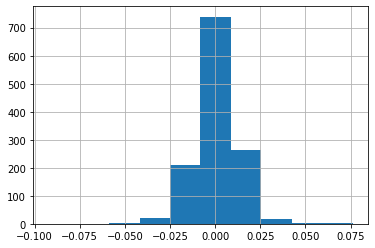

In [23]:
df['return'].hist()

In [0]:
series = df['return'].values[1:].reshape(-1,1)
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

## Model 1

In [32]:
T = 10
D = 1
X = []
Y = []

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,D)
Y = np.array(Y)
N = len(X)

print(f'Shape of X: {X.shape}, Shape of Y: {Y.shape}')

Shape of X: (1248, 10, 1), Shape of Y: (1248,)


In [0]:
i = Input(shape=(T,D))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i,x)

model.compile(loss='mse',optimizer=Adam(lr=0.01))

In [36]:
model.fit(X[:-N//2],Y[:-N//2],
          epochs=80,
          validation_data=(X[-N//2:],Y[-N//2:]))

Epoch 1/80
20/20 [==============================] - 1s 28ms/step - loss: 0.9913 - val_loss: 1.1734
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9840 - val_loss: 1.1815
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9740 - val_loss: 1.1712
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9765 - val_loss: 1.1660
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9846 - val_loss: 1.1723
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9701 - val_loss: 1.1684
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9786 - val_loss: 1.1730
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0507 - val_loss: 1.1737
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9762 - val_loss: 1.1672
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9902 - val_loss: 1.1744
Epoch 11/80
20/20 

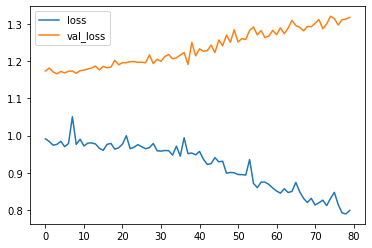

In [37]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['loss'],label='loss')
plt.plot(losses['val_loss'],label='val_loss')
plt.legend()
plt.show()

### Forecasting

In [0]:
validation_data = Y[-N//2:]
validation_pred = []
last_x = X[-N//2]

while len(validation_pred) < len(validation_data):
  
  pred = model.predict(last_x.reshape(-1,T,D))[0,0]
  validation_pred.append(pred)
  last_x = np.roll(last_x,-1)
  last_x[-1] = pred

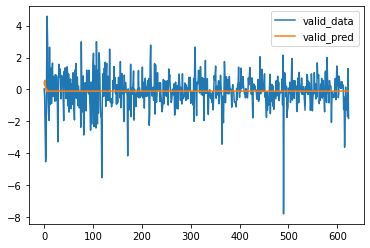

In [43]:
plt.plot(validation_data,label='valid_data')
plt.plot(validation_pred,label='valid_pred')
plt.legend()
plt.show()

## Model 2

In [45]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name', 'PrevClose',
       'return'],
      dtype='object')

In [0]:
input_data = df[['open','high','low','close','volume']].values
targets = df['return'].values

In [0]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [0]:
Ntrain = len(input_data)* 2//3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data = scaler.transform(input_data)

### Train and Test split

In [0]:
X_train = np.zeros((Ntrain,T,D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
X_test = np.zeros((N-Ntrain,T,D))
Y_test = np.zeros((N-Ntrain))

for u in range(N-Ntrain):
  t = u + Ntrain
  X_test[u,:,:] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
i = Input(shape=(T,D))
x = LSTM(50)(i)
x = Dense(1,activation='sigmoid')(x)

model = Model(i,x)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [66]:
model.fit(X_train,Y_train,
          validation_data=(X_test,Y_test),
          epochs=300,
          batch_size=32)

Epoch 1/300
27/27 [==============================] - 1s 20ms/step - loss: 0.6925 - accuracy: 0.5221 - val_loss: 0.6985 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5304 - val_loss: 0.6944 - val_accuracy: 0.5049
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.4958 - val_loss: 0.6917 - val_accuracy: 0.5439
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5268 - val_loss: 0.6967 - val_accuracy: 0.4927
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5149 - val_loss: 0.6965 - val_accuracy: 0.4951
Epoch 6/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6882 - accuracy: 0.5507 - val_loss: 0.6927 - val_accuracy: 0.4829
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6889 - accuracy: 0.5399 - val_loss: 0.6951 - val_accuracy: 0.4829
Epoch 8/300


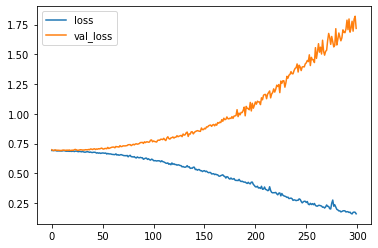

In [67]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['loss'],label='loss')
plt.plot(losses['val_loss'],label='val_loss')
plt.legend()
plt.show()

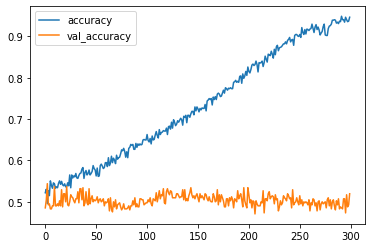

In [68]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['accuracy'],label='accuracy')
plt.plot(losses['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()